In [2]:
import torch
from torch import  nn 
from d2l import torch as d2l
import math
import collections

首先，看一看这篇文章可以大概了解到embeddding的作用。[链接](https://zhuanlan.zhihu.com/p/83814532)
* 与one-hot有相同的作用，将特征或者词元的数据进行归一化，方便矩阵计算。
* 与one-hot不同的是，embedding将离散变量转换为连续变量。
* 对数据进行降维和升维。
* embedding是可以学习的。


In [99]:
class Seq2SeqEncoder( d2l.Encoder ):
    '''编码器结构'''
    def __init__( self , vocab_size , embed_size , num_hiddens , 
                num_layers , dropout = 0 , **kwargs ):
        super().__init__( **kwargs )
        self.embedding = nn.Embedding( vocab_size , embed_size )
        #使用GRU高级api进行操作，记住nn.GRU之类的rnn算子记住两点：
        # 1.vocab_size---->num_hiddens
        # 2.返回的是( output , state )
        self.rnn = nn.GRU( embed_size , num_hiddens  , num_layers , dropout  = dropout )
    def forward( self ,  X  , *args ):#传入可变参数
        #( batch_size , num_steps )---->( batch_size , num_steps , embed_size )
        X = self.embedding( X )
        #( batch_size , num_steps , embed_size )---->( num_steps , batch_size  , embed_size )
        X = X.permute( 1 , 0 , 2 )
        output , state = self.rnn(  X )#可以不传入state,初始state为None
        return output , state 

In [100]:
#测试一下编码器encoder
encoder = Seq2SeqEncoder( vocab_size = 10 , embed_size= 8 , num_hiddens= 16 , num_layers= 2 )
encoder.eval()#评估状态
#batch_size为4 , 时间步为7
X = torch.zeros(size=( 4 , 7 ) , dtype= torch.long  )#一定要注意
# print( X.dtype )
output , state = encoder( X )
output.shape , state.shape#( num_steps  , batch_size , num_hiddens ) , ( num_layers , batch_size , num_hiddens  )

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [101]:
#解码器
#X的shape为( batch_size ,  )
# X = torch.rand( 7 , 4 , 8 )
# context = state[-1].repeat(X.shape[0], 1, 1)#将上下文变量转换
# X_and_context = torch.cat((X, context), 2)
# X_and_context.shape

In [102]:
class Seq2SeqDecoder( d2l.Decoder ):
    def __init__( self , vocab_size , embed_size,  num_hiddens , num_layers , dropout = 0 , **kwargs ):
        super().__init__( **kwargs )
        self.embedding = nn.Embedding( vocab_size , embed_size )
        #embed_size + num_hiddens是将target的embed_szie输入与上个状态的隐藏状态
        #在文中描述的是当前时间步将它们和上一隐藏状态 st′−1 转换为隐藏状态 st′
        self.rnn = nn.GRU( embed_size + num_hiddens ,  num_hiddens  , num_layers , dropout = dropout  )
        #通过线性变换，将隐藏状态通过一个w_o和b_o得到输出output---->( num_stps , batch_size , vocab_size )
        self.dense = nn.Linear( num_hiddens ,  vocab_size )
    def init_state( self ,  encoder_outputs , *args ):
        #注意encoer(x)返回的是( output , state )所以我们要将编码器的隐藏状态取出来，
        # shape为( num_layers , batch_szie , num_hiddens )
        return encoder_outputs[1]
    def forward( self , X , state ):
        # ( batch_size , num_steps ) --->( batch_size , num_steps , embed_size )--->( num_steps , batch_size , embed_size )
        X = self.embedding( X ).permute( 1 , 0 , 2 )
        # print( state.shape )
        #state[-1]的shape为( batch_size , num_hiddens )--->( num_steps , batch_size  , num_hiddens )
        #这一步是要将隐藏状态的最后一层输出起名为上下文变量，这个上下文变量与输入X进行拼接
        #那么首先要保证上下文变量的时间步与输入X的时间步相同，上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）
        context = state[-1].repeat( X.shape[0] , 1,1 )
        # print( X.shape ,  context.shape)
        #( num_steps , batch_size  , embed_size ) + ( num_steps , batch_size  , num_hiddens )
        # --->( num_steps , batch_size  , embed_size+num_hiddens )
        X_and_context = torch.cat( ( X , context ) , 2 )
        output , state = self.rnn( X_and_context , state )
        output = self.dense( output ).permute( 1 , 0 , 2 )
        # `output`的形状: (`batch_size`, `num_steps`, `vocab_size`)
        # `state[0]`的形状: (`num_layers`, `batch_size`, `num_hiddens`)
        return output , state

In [103]:
x = torch.rand( 2 ,  3 ,4 )
y = torch.ones(3 ,5  )
y = y.repeat( x.shape[0] , 1 ,1 )
torch.cat( ( x , y ), dim= 2  ).shape#显然这段话的意思就是在轴2上进行拼接

torch.Size([2, 3, 9])

In [104]:
# 我们用与前面提到的编码器中相同的超参数，来实例化解码器
decoder = Seq2SeqDecoder( vocab_size= 10 , embed_size = 8 , num_hiddens= 16 , num_layers= 2 )
decoder.eval()
#初始化隐藏状态
state = decoder.init_state( encoder( X ) )
output , state = decoder( X , state )
output.shape , state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## 损失函数

In [29]:
def sequence_mask( X  , valid_len , value = 0  ):
    '''在序列中屏蔽不相关的项'''
    maxlen = X.size( 1 )
    # [ None , : ] 这种写法相当于增加维度，返回的mask是一个bool的tensor，这里用到了广播机制
    mask = torch.arange( ( maxlen ) , dtype= torch.float32 , device = X.device  )[ None , : ] < valid_len[ : , None ]
    # print( mask )
    print( X[ ~mask ] )
    X[ ~mask ] = value
    
    return X

In [34]:
'''
1.初始变量
maxlen = 3
torch.arange( 3 )[ None , : ] =  [ [ 0  , 1 , 2 ] , 
                                 [ 0  , 1 , 2 ]] 
 valid_len[ : , None ] = [ [ 1 ], 
                          [ 2 ] ]
广播机制 ---> valid_len[ : , None ] = [  [ 1 , 1 , 1] , 
                                          [2 , 2 ,2 ] ]

2.进行比对
mask = [ [ T , F , F ] , 
          [ T , T , F ] ]

3.X[ ~mask ] = tensor([[1., 1., 1., 1.],
        #               [1., 1., 1., 1.],
        #               [1., 1., 1., 1.]])
这里的第一行第二行是X中第一个样本的第二,三行,第三行为第二个样本的最后一行，之后全部赋值为0，得到了现在的结果
'''
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]))


tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


tensor([[[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])

In [31]:
#广播机制
torch.ones( 2 , 2  )[None , : ] < torch.tensor( [ 1 , 2 ])[ :  , None ]
# torch.ones( 2  , 2  ).unsqueeze( 0 ) < torch.tensor( [1 , 2 ] ).reshape( 2  ,1 )

tensor([[[False, False],
         [ True,  True]]])

In [108]:
class MaskedSoftmaxCELoss( nn.CrossEntropyLoss ):
    '''带遮蔽的交叉熵损失函数'''
    # preds:( batch_size , num_steps , vocab_size )
    # label:( batch_size , num_steps )
    # valid_len:( batch_size , )
    def forward( self , preds , label , valid_len ):
        weights = torch.ones_like( label )
        weights = sequence_mask( weights ,  valid_len )#得到的经过遮蔽的权值数据
        self.reduction = 'none'
        #这一步是不对loss进行求mean操作，因为我们后续需要对所有预测词元产生的损失乘以掩码，以过滤掉损失中产生的不相关预测
        unweighted_loss = super( MaskedSoftmaxCELoss ,  self ).forward( 
            preds.permute( 0 , 2 ,1 ) , label
        )
        weighted_loss = ( unweighted_loss * weights ).mean( dim=1 )#按列对元素进行求mean，实际上就是对每一行求
        return weighted_loss
    

In [109]:
loss = MaskedSoftmaxCELoss()
loss( torch.ones( 3 ,4  , 10 ) ,torch.ones( size=( 3 ,4 ) , dtype= torch.long )  , torch.tensor( [ 4 , 2 , 0] ) )

tensor([2.3026, 1.1513, 0.0000])

In [110]:
def train_seq2seq( net , data_iter , lr , num_epochs , tgt_vocab , device ):
    def xavier_init_weights(m):#初始化
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply( xavier_init_weights )
    net.to( device )
    optimizer = torch.optim.Adam( net.parameters() ,  lr )
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator =  d2l.Animator( xlabel='epochs' , ylabel='loss' , xlim=[10 ,  num_epochs ])
    for epoch in range( num_epochs ):
        metrics = d2l.Accumulator( 2 )#累积loss和词元数量
        timer = d2l.Timer()
        for batch in data_iter:
            optimizer.zero_grad()
            #将数据送入gpu
            X, X_valid_len , Y , Y_valid_len = [  x.to( device )    for x in batch  ]
            #将起始符号'<bos>'加入target_vocab的开头,注意这里要将bos的组成一个( batch_size , 1 )大小的tensor,
            #方便bos与Y进行组装
            bos = torch.tensor(  [ tgt_vocab[ '<bos>'] ] * ( Y.shape[ 0 ] )  , device= device ).reshape( -1 , 1 )
            dec_input = torch.cat( [ bos , Y[ : , :-1 ] ] , dim= 1 )#注意这里[]和()都可以
            Y_hat , _ =net( X , dec_input ,  X_valid_len )#这里加入X_valid_len我并不清楚有什么用，因为我在翻阅encoder和decoder
            #的时候发现并没用到这个变量
            l = loss( Y_hat , Y , Y_valid_len )#Y_valid_len对不必要的loss进行遮蔽
            l.sum().backward()#反向传播
            d2l.grad_clipping( net , 1 )#梯度裁剪
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metrics.add( l.sum() , num_tokens )
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metrics[0] / metrics[1],))
    print( f'loss:{ (metrics[0] / metrics[1]  ):.3f} , {metrics[1]/ timer.stop():.1f} tokens/sec on cuda{str( device )}')


loss:0.019 , 8710.2 tokens/sec on cudacuda:0


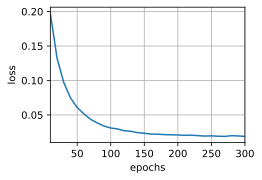

In [111]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder( len(src_vocab ) , embed_size= embed_size , num_hiddens= num_hiddens , 
                            num_layers= num_layers , dropout= dropout )
decoder = Seq2SeqDecoder( len( tgt_vocab ) , embed_size= embed_size , num_hiddens= num_hiddens ,
                            num_layers= num_layers , dropout= dropout )
net = d2l.EncoderDecoder( encoder , decoder )
train_seq2seq( net , train_iter , lr , num_epochs , tgt_vocab , device )

In [112]:
# torch.tensor([tgt_vocab['<bos>'] ] * batch_size).reshape(-1,1)

In [113]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将`net`设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [114]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


In [125]:
engs = 'fuck you .'
translation, attention_weight_seq = predict_seq2seq(
        net, engs, src_vocab, tgt_vocab, num_steps, device)
print(f'{engs} => {translation}')


fuck you . => <unk> vous .
